# MSA 2024 Phase 2 - Part 2

In [259]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from prophet import Prophet
%matplotlib inline

## 1. Load and split preprocessed data

In [260]:
#get cleaned data
PATH_ROOT = Path(os.getcwd()).parent
PATH_X = PATH_ROOT /'0. Resources'/ 'datasets' / 'X store sales' / 'sales_clean.csv'

print(f"Path: {PATH_X}")
df = pd.read_csv(PATH_X,index_col=0)
df.head()

Path: /Users/vitaliigalkin/Desktop/MSA-Phase2/data-science/0. Resources/datasets/X store sales/sales_clean.csv


,Sales,Quantity,Discount,Profit,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,Region_East,Region_South,Region_West,Sub-Category_Chairs,Sub-Category_Furnishings,Sub-Category_Tables
Order Date,,,,,,,,,,,,,,,
2014-01-07,76.728,3,0.60,-53.7096,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2014-01-10,51.940,1,0.00,21.2954,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2014-01-11,9.940,2,0.00,3.0814,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2014-01-13,879.939,9,0.15,91.2798,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2014-01-14,61.960,4,0.50,-53.2856,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [261]:
df.index = pd.to_datetime(df.index)

# Define the training and test data
train = df[:'2017-03-31']
test = df['2017-04-01':'2017-12-31']

### predict 4 weeks

## 2. Choose an algorithm

## Sales Forecasting

Sales forecasting involves predicting future sales based on historical data. In our dataset, we use the feature "sales" as the target variable, which means it is a supervised machine learning task. Additionally, when dealing with trends and financial numeric data, regression is often used, and evaluation for regression is typically done using various metrics.

For this sales forecasting task, I have chosen **ARIMA** and **Prophet** as the primary methods because they offer advantages over traditional linear regression, particularly in handling time series data. Both methods also include built-in plotting functions that allow for comparison between predictions and actual data. Moreover, the ADF test confirms that the dataset is stationary, which means they all belong to the same distribution and has same statitical property,  making it suitable for time series algorithms and ensuring that the distribution is meaningful.

### ARIMA (AutoRegressive Integrated Moving Average)

ARIMA is a time series forecasting method that combines three components:
- **Autoregression (AR)**:  This component uses a linear weighted combination of previous time lags. The key is to determine the optimal number of lags (p) to include in the model and assess their significance.
- **Differencing (I)**: Involves subtracting the previous observation from the current observation to achieve stationarity in the data. This process helps remove trends and make the time series data suitable for modeling. We can use cox-box transform or log and deffernce transformation.
- **Moving Average (MA)**: This component models the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA models temporal dependencies in the data, adjusting for trends and seasonality to make future predictions. It is particularly effective for univariate time series forecasting.

### Prophet

Developed by Facebook, Prophet is designed for time series forecasting, especially for data that exhibits strong seasonal patterns and includes missing values or outliers. Prophet decomposes time series into:
- **Trend**: Long-term progression of the time series.
- **Seasonality**: Regularly repeating patterns or cycles.
- **Holiday Effects**: Special events that impact the time series.

Prophet provides a flexible and interpretable forecasting model and is user-friendly, allowing easy customization for specific business needs.


In [262]:
from statsmodels.tsa.stattools import adfuller

time_series = df['Sales']

# Perform the ADF test
adf_result = adfuller(time_series)
# Extracting the results
adf_statistic = adf_result[0]
p_value = adf_result[1]
used_lag = adf_result[2]
num_obs = adf_result[3]
critical_values = adf_result[4]

# Displaying the results
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', used_lag)
print('Number of Observations Used:', num_obs)
print('Critical Values:', critical_values)

if p_value < 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -6.860105908465945
p-value: 1.6106362761575634e-09
Number of Lags Used: 9
Number of Observations Used: 876
Critical Values: {'1%': -3.437836947046742, '5%': -2.864845006291261, '10%': -2.5685298249098225}
The time series is likely stationary.


## 3. Train and test a model

### ARIMA (AutoRegressive Integrated Moving Average)

### Hyperparameter Tuning for ARIMA Models

Hyperparameter tuning is a crucial step in building ARIMA models, as it helps determine the optimal values for the parameters `p`, `d`, and `q`. and we use grid search to find the best AIC.

#### Overview of ARIMA Parameters

- **`p` (Autoregressive Order)**: The number of lag observations included in the model. It represents how many previous periods' values are used to predict the current period.
- **`d` (Differencing Order)**: The number of times the data needs to be differenced to achieve stationarity. This parameter helps in making the time series stationary.
- **`q` (Moving Average Order)**: The size of the moving average window. It indicates the number of lagged forecast errors included in the model.

#### Hyperparameter Tuning Steps

##### 1. **Initial Parameter Selection**

- **Determine `d` (Differencing Order)**: Start with `d` values of 0, 1, or 2. Use the ADF test results to find the optimal differencing order that makes the series stationary.

- **Select `p` and `q` (AR and MA Orders)**: Use the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) plots to identify initial values for `p` and `q`. 

##### 2. **Grid Search**

Grid Search is an exhaustive search method used to find the best combination of hyperparameters.



In [263]:
# hyper parameter tuning (using training data):
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')

best_aic = float("inf")
best_order = None
best_model = None

# Iterate over a range of p, d, q values
for p in range(5):  
    for d in range(2):  
        for q in range(5): 
            try:
                model = ARIMA(train['Sales'], order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except Exception as e:
                continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')


Best ARIMA order: (0, 1, 1) with AIC: 11022.684285155243


- train ARIMA model

In [264]:
# Exogenous variables for training and test sets
exog_train = train.copy().drop(columns=['Sales'])
exog_test = test.copy().drop(columns=['Sales'])

# Build and fit the model on the training set
model = ARIMA(train['Sales'], exog=exog_train, order=(0, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  676
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -5088.970
Date:                Mon, 29 Jul 2024   AIC                          10209.941
Time:                        23:56:24   BIC                          10282.176
Sample:                             0   HQIC                         10237.911
                                - 676                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Quantity                    76.1769      4.133     18.432      0.000      68.077      84.277
Discount                   152.7024     62.788      2.432      0.015      29.640     275.

Overall, the model indicates several predictors with significant effects on sales, including Quantity, Discount, Profit, and some shipping modes and categories. However, some variables, like certain segments and regions, do not show statistically significant effects on sales. The model provides a comprehensive view of how different factors impact sales, which can be valuable for making data-driven business decisions.

some explaination of the P-value(hypothesis testing for the statistical significance of the coefficient) and coeffience(slope):
**- Quantity**: The coefficient is 76.1769 and the p-value is 0.000. From these values, we can infer that a unit increase in quantity is associated with an increase of approximately 76.18 units in sales, and this effect is statistically significant.

**- Discount**: The coefficient is 152.7024 and the p-value is 0.015. This indicates that each unit increase in discount is associated with an increase of 152.70 units in sales, with the effect being statistically significant.

**- Profit**: The coefficient is 1.0698 and the p-value is 0.000. This suggests that an increase of one unit in profit corresponds to an increase of approximately 1.07 units in sales, and this effect is highly significant.

**- Ship Mode_Same Day**: The coefficient is 51.6842 and the p-value is 0.092. This implies that shipping via "Same Day" is associated with an increase of approximately 51.68 units in sales, although this effect is not statistically significant at the 5% level.

**- Ship Mode_Second Class**: The coefficient is 47.5290 and the p-value is 0.077. This means that shipping via "Second Class" increases sales by approximately 47.53 units, with the effect being only marginally significant.




- test ARIMA model

In [265]:
start_position = len(train) 
end_position = start_position + len(test) -1

end_date = test.index.max()
print(start_position)
# Forecasting sales for the specified period
predictions_arima = model_fit.predict(start=start_position, end=end_position, exog=exog_test, dynamic=False)

# Display predictions
print(predictions_arima)

676
676    1143.845363
677     553.868936
678     119.481145
679     946.074241
680     289.625131
          ...     
881    1648.570529
882    1325.865193
883    1221.289170
884    2747.961740
885     418.767244
Name: predicted_mean, Length: 210, dtype: float64


- plot ARIMA in graph

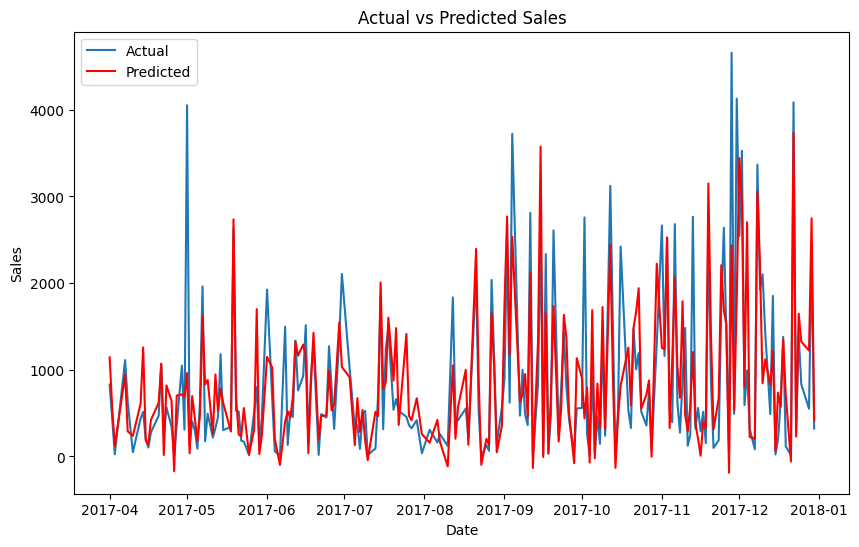

In [266]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Sales'], label='Actual')
plt.plot(test.index, predictions_arima, label='Predicted', color='red')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Prophet

- make the data into correct format

In [267]:
train_prophet = train.reset_index() .rename(columns={'Order Date':'ds',
                     'Sales':'y'})
test_prophet =test.reset_index() .rename(columns={'Order Date':'ds',
                     'Sales':'y'})

- train prophet model

In [268]:
model_proph = Prophet()
model_proph.fit(train_prophet)

23:56:25 - cmdstanpy - INFO - Chain [1] start processing
23:56:25 - cmdstanpy - INFO - Chain [1] done processing


- test prophet model

In [269]:
test_predict = model_proph.predict(test_prophet)

- plot prophet model

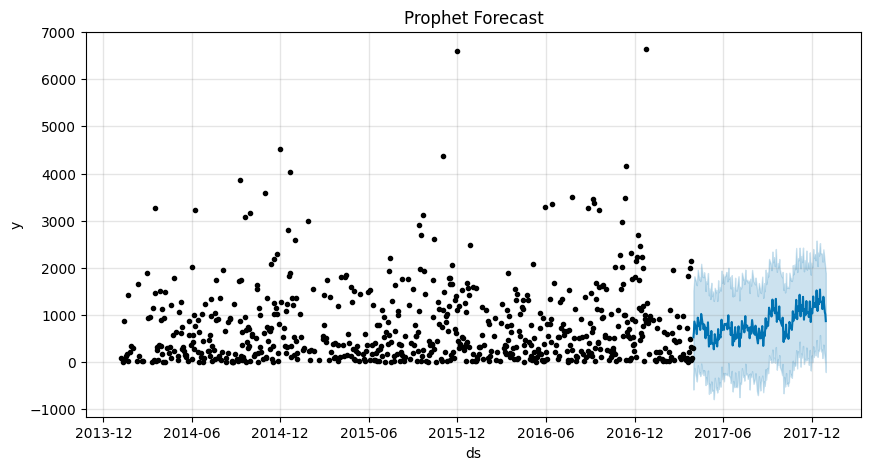

In [270]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_proph.plot(test_predict, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

(0.0, 3000.0)

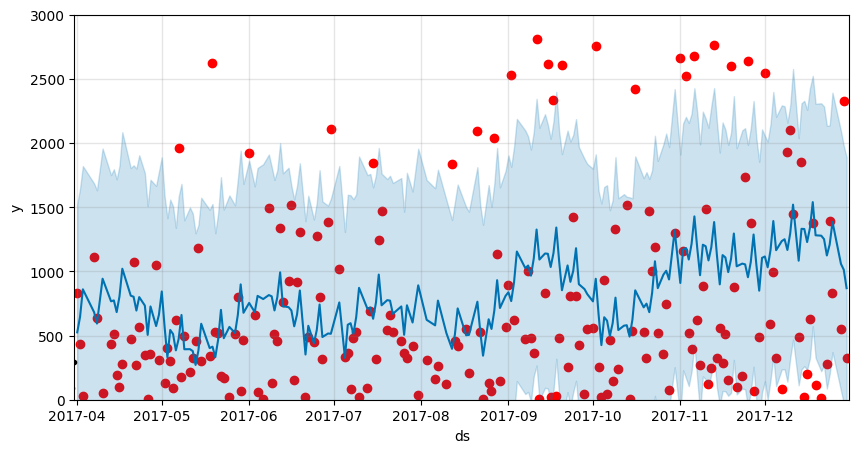

In [271]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['Sales'], color='r')
fig = model_proph.plot(test_predict, ax=ax)

# Corrected example dates as strings
lower_bound = '31-03-2017'
upper_bound = '31-12-2017'

# Convert date strings to datetime objects
lower_bound_dt = pd.to_datetime(lower_bound, format='%d-%m-%Y')
upper_bound_dt = pd.to_datetime(upper_bound, format='%d-%m-%Y')
ax.set_xbound(lower=lower_bound_dt, upper=upper_bound_dt)
ax.set_ylim(0, 3000)

## 4. Evaluate the model 

In [294]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score

def smape(y_true, y_pred):
    """Calculate Symmetric Mean Absolute Percentage Error (SMAPE)."""
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

def evaluation(model, pred):
    mse = mean_squared_error(test['Sales'], pred)
    mae = mean_absolute_error(test['Sales'], pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true=test['Sales'], y_pred=pred)
    smape_value = smape(test['Sales'], pred)
    Rs = r2_score(y_true=test['Sales'], y_pred=pred)

    print(f'{model} MSE: {mse}')
    print(f'{model} MAE: {mae}')
    print(f'{model} RMSE: {rmse}')
    print(f'{model} MAPE: {mape}')
    print(f'{model} SMAPE: {smape_value}')
    print(f'{model} R squared: {Rs}')

Explain each evaluation:
- Mean Squared Error (MSE): MSE measures the average squared difference between the predicted and actual values.
  - **Formula**: `MSE = (1 / n) * Σ (y_i - ŷ_i)^2`
   - **Where**:
     - `n` is the number of observations
     - `y_i` is the actual value for observation `i`
     - `ŷ_i` is the predicted value for observation `i`
- Mean Absolute Error(MAE): MAE measures the average absolute difference between the predicted and actual values. It provides a straightforward indication of the average prediction error.
  - **Formula**: `MAE = (1 / n) * Σ |y_i - ŷ_i|`
  - **Where**:
      - `n` is the number of observations
      - `y_i` is the actual value for observation `i`
      - `ŷ_i` is the predicted value for observation `i`
- Root Mean Squared Error: RMSE is the square root of MSE and provides an error metric in the same units as the dependent variable. It measures the square root of the average squared differences between predicted and actual values.
    - **Formula**: `RMSE = sqrt MSE`
    - **Where**:
      - `n` is the number of observations
      - `y_i` is the actual value for observation `i`
      - `ŷ_i` is the predicted value for observation `i`

- Mean Absolute Percentage Error (MAPE): MAPE measures the average absolute percentage error between predicted and actual values. It expresses prediction error as a percentage of the actual values, providing a relative measure of accuracy.
  - **Formula**: `MAPE = (100 / n) * Σ |(y_i - ŷ_i) / y_i|`
   - **Where**:
     - `n` is the number of observations
     - `y_i` is the actual value for observation `i`
     - `ŷ_i` is the predicted value for observation `i`
- Symmetric Mean Absolute Percentage Error (SMAPE): SMAPE is a metric used to evaluate the accuracy of forecasts. It is similar to the Mean Absolute Percentage Error (MAPE), but with an adjustment that helps to avoid some of the problems MAPE can have, such as infinite or undefined values when actual values are close to zero.
   - **Formula**: `SMAPE = (1 / n) * Σ (|y_i - ŷ_i| / ((|y_i| + |ŷ_i|) / 2)) * 100`
   - **Where**:
     - `n` is the number of observations
     - `y_i` is the actual value for observation `i`
     - `ŷ_i` is the predicted value for observation `i`

- R-Squared (R²): R-Squared, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, where 1 indicates that the model perfectly predicts the outcome.
  - **Formula**: `R^2 = 1 - [Σ (y_i - ŷ_i)^2 / Σ (y_i - ȳ)^2]`
   - **Where**:
     - `n` is the number of observations
     - `y_i` is the actual value for observation `i`
     - `ŷ_i` is the predicted value for observation `i`
     - `ȳ` is the mean of the actual values


    

## for ARIMA model

In [295]:
evaluation("ARIMA", predictions_arima)

ARIMA MSE: 333146.27606311324
ARIMA MAE: 381.40467683289415
ARIMA RMSE: 577.1882501083276
ARIMA MAPE: 1.67251452756128
ARIMA SMAPE: 62.268357917799875
ARIMA R squared: 0.6197271314688093


Mean Squared Error (MSE): 333,146.28. A higher MSE indicates larger errors in predictions. In this case, the model shows a high MSE, suggesting significant deviations from actual sales values. It is normal beacsause it is regression model and the variance can be big.

Mean Absolute Error (MAE): 381.40. The MAE indicates  on average, predictions deviate by approximately 381.40 units from the true values.

Root Mean Squared Error (RMSE): 577.19. It penalizes larger errors more severely, and the value of 577.19 suggests considerable variability in the prediction errors.

Mean Absolute Percentage Error (MAPE): 1.67%. MAPE measures the average absolute percentage error between actual and predicted values.A MAPE of 1.67% implies that predictions are 1.67% off from actual values. This indicates relatively high accuracy.

Symmetric Mean Absolute Percentage Error (SMAPE): 62.27%. A SMAPE of 62.27% indicates substantial discrepancies between actual and predicted values, suggesting room for improvement in model performance.

R-Squared (R²): 0.62. With an R² of 0.62, the model explains 62% of the variance in sales, indicating a moderate fit and suggesting that the model captures a significant portion of the variance.

In [296]:
evaluation("prophet", test_predict['yhat'])

prophet MSE: 809297.2151754799
prophet MAE: 651.5884866579614
prophet RMSE: 899.6094792605733
prophet MAPE: 6.907679132629518
prophet SMAPE: 79.81298527832709
prophet R squared: 0.07622028033481243


Mean Squared Error (MSE) is 809,297.22, indicating large average squared errors between predicted and actual values. 
    
Mean Absolute Error (MAE) stands at 651.59, reflecting an average absolute deviation of 651.59 units from the true values. 
    
The Root Mean Squared Error (RMSE) is 899.61, showing the average magnitude of prediction errors and emphasizing larger deviations. 
    
Mean Absolute Percentage Error (MAPE) is 6.91%, suggesting that, on average, predictions deviate by 6.91% from the actual values. 

Symmetric Mean Absolute Percentage Error (SMAPE) is 79.81%, indicating significant relative errors when compared to the actual values. 
    
R-Squared (R²) value is 0.08, meaning that only 8% of the variance in the sales data is explained by the model, which suggests a poor fit and limited explanatory power.



## 5. Summary

Based on the evaluation metrics, the **ARIMA** model outperforms the **Prophet** model across all key measures:

- **Mean Squared Error (MSE)**: ARIMA (333,146.28) vs. Prophet (809,297.22) --- lower better
- **Mean Absolute Error (MAE)**: ARIMA (381.40) vs. Prophet (651.59) --- lower better
- **Root Mean Squared Error (RMSE)**: ARIMA (577.19) vs. Prophet (899.61) --- lower better
- **Mean Absolute Percentage Error (MAPE)**: ARIMA (1.67%) vs. Prophet (6.91%) --- lower better
- **Symmetric Mean Absolute Percentage Error (SMAPE)**: ARIMA (62.27%) vs. Prophet (79.81%) --- lower better
- **R-Squared (R²)**: ARIMA (0.62) vs. Prophet (0.08) --- higher better

ARIMA provides more accurate, precise, and reliable predictions compared to Prophet. **Prophet** shows higher error values and explains a smaller proportion of variance, suggesting it may be less suitable for this specific forecasting task.

**Summary:**

- ARIMA outperforms Prophet in terms of all key evaluation metrics: MSE, MAE, RMSE, MAPE, SMAPE, and R².
- ARIMA provides more accurate, precise, and reliable predictions compared to Prophet.
- Prophet shows higher error values and explains a smaller proportion of variance, indicating it may be less suitable for this specific forecasting task.


**Models select**:

   - **ARIMA (AutoRegressive Integrated Moving Average)**:
   build model based on previous time lags
    

   - **Prophet**:
     Developed by Facebook, Prophet is designed for time series forecasting with strong seasonal patterns and missing values. 

**Hyperparameter Tuning**:
   Hyperparameter tuning was used to determine the optimal values for the ARIMA parameters.
    This involved:
   - **Grid Search**: Evaluating a range of parameter values to find the best combination.

**Interesting and futher exploration**
  During the initial experimentation, I did not group the data by date before training and testing the models. Surprisingly, this approach resulted in better performance for the ARIMA model compared to the current implementation, but it was less effective for the Prophet model. 

  Upon grouping the data by date and re-evaluating, it became evident that the ARIMA model is highly sensitive to the structure of the dataset. The initial non-grouped data provided a richer set of patterns for the model to learn from, which contributed to its improved performance. Conversely, Prophet, which is designed to handle structured time series data, did not benefit from this approach as much.

  These findings highlight the importance of data preprocessing and the impact of data structure on model performance. Further exploration could involve experimenting with different data aggregation methods, model parameters, and preprocessing techniques to enhance the accuracy and robustness of both ARIMA and Prophet models.

  Also, the dataset is quite small after aggreating the data by date, so the accuracy can be still improve by getting more data which can also help reduce bias and enhance the model complexity